In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

sns.set_style('darkgrid')
%matplotlib inline

/home/queimadas/.conda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('conhecimento.csv')

In [3]:
id_cenas = sorted(df[df.id_cena.str.contains('2210672017')].id_cena.unique())

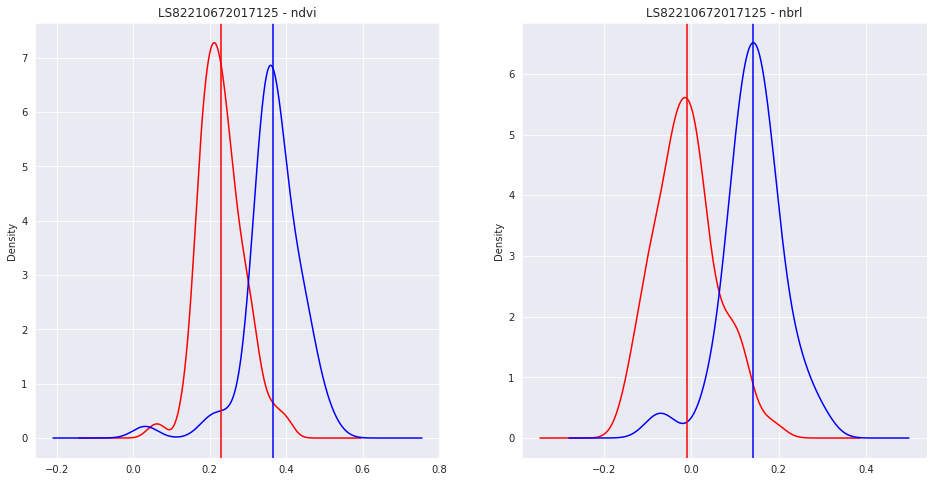

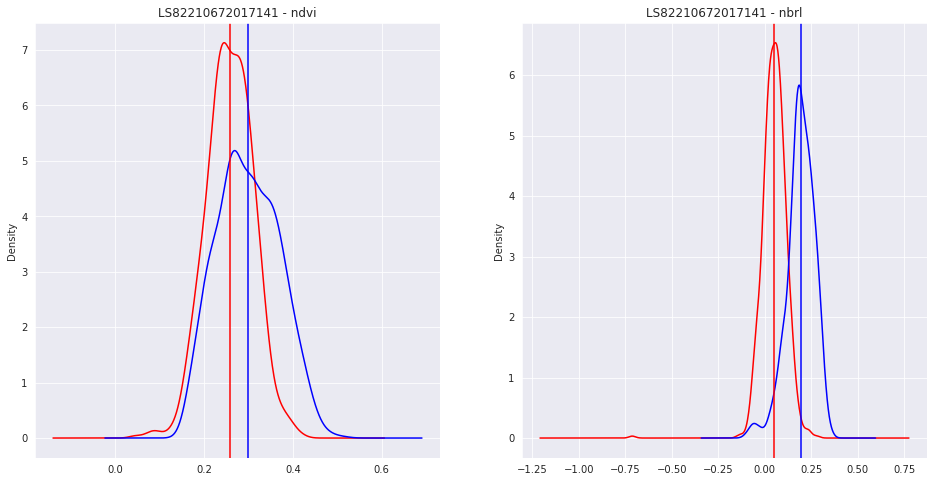

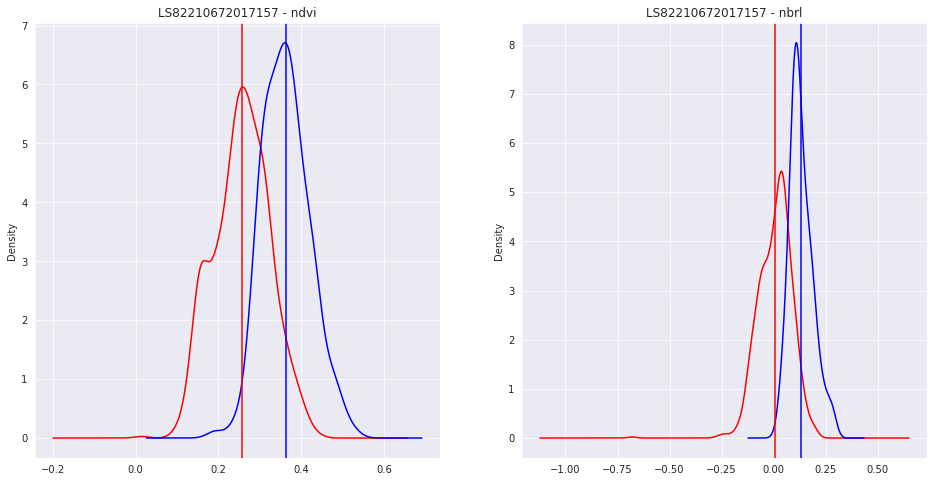

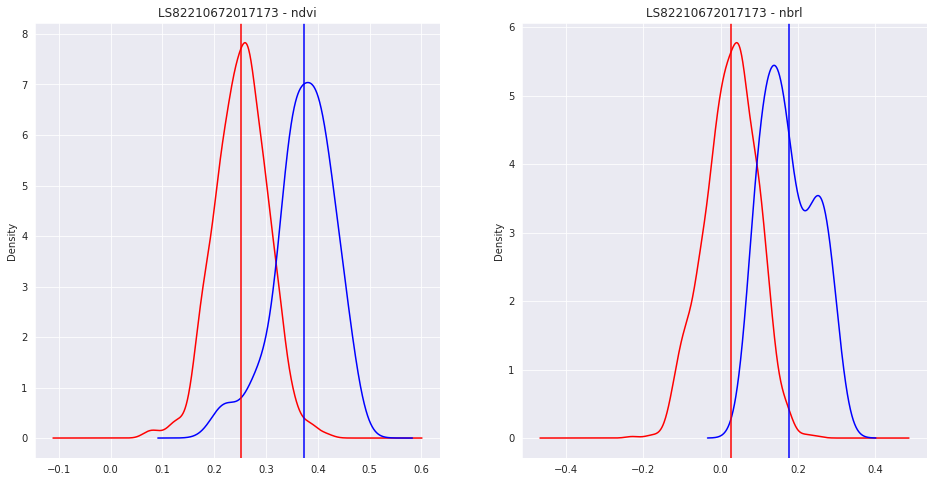

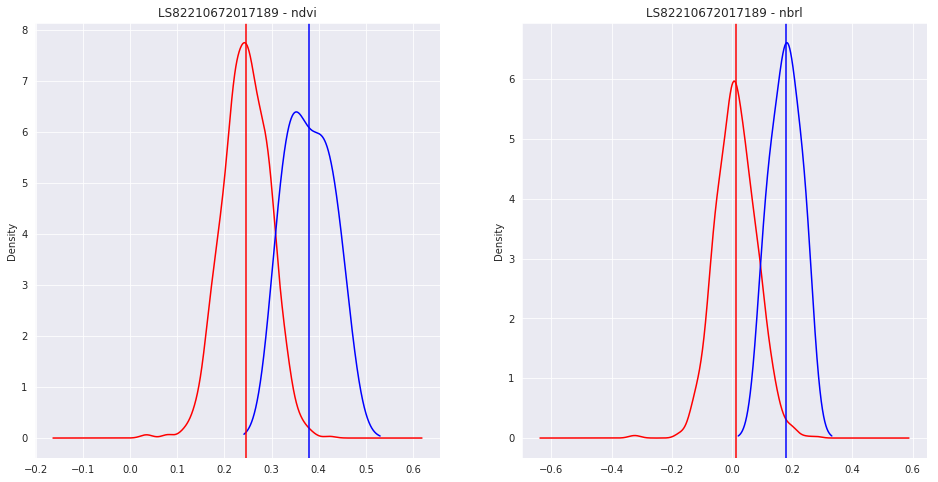

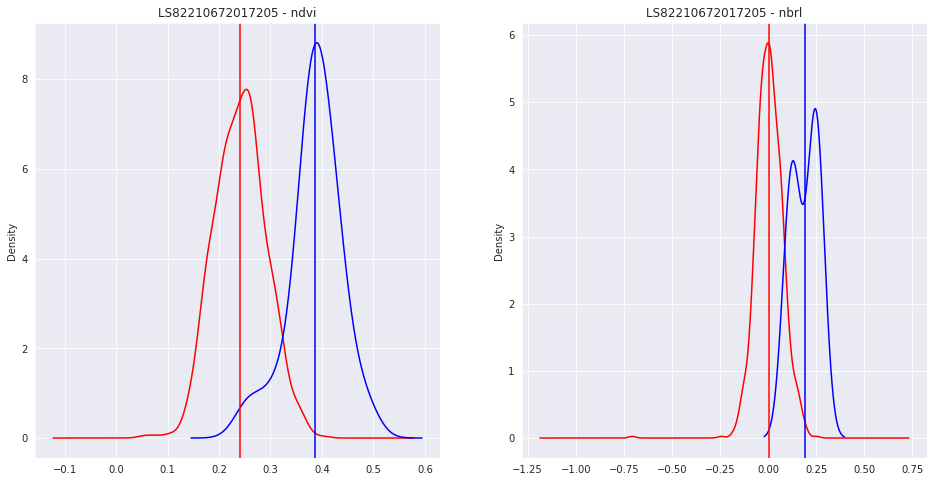

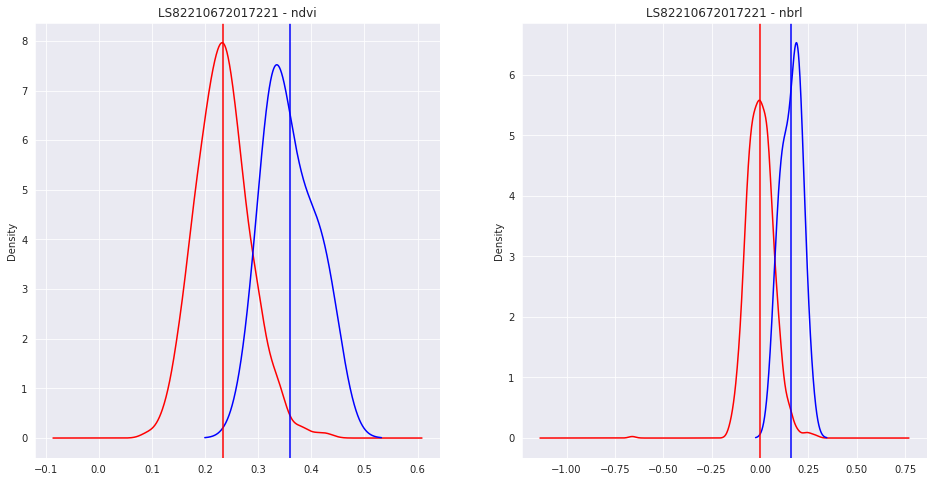

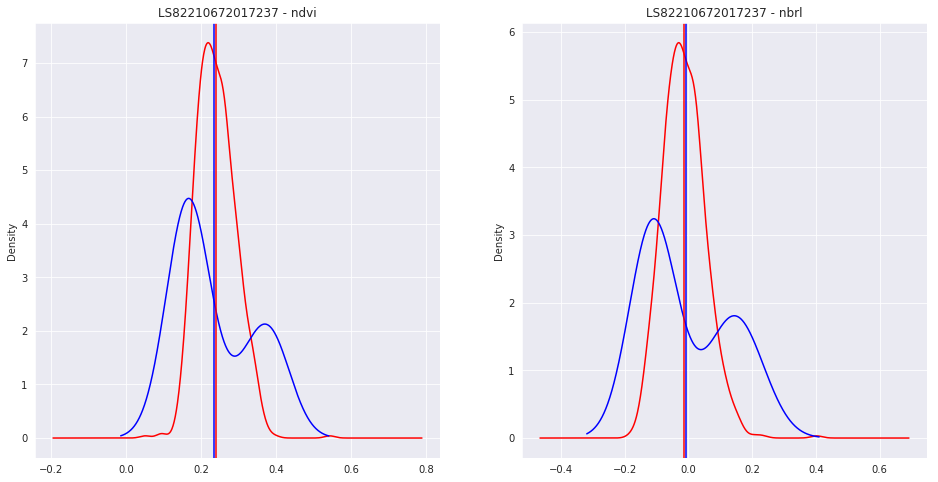

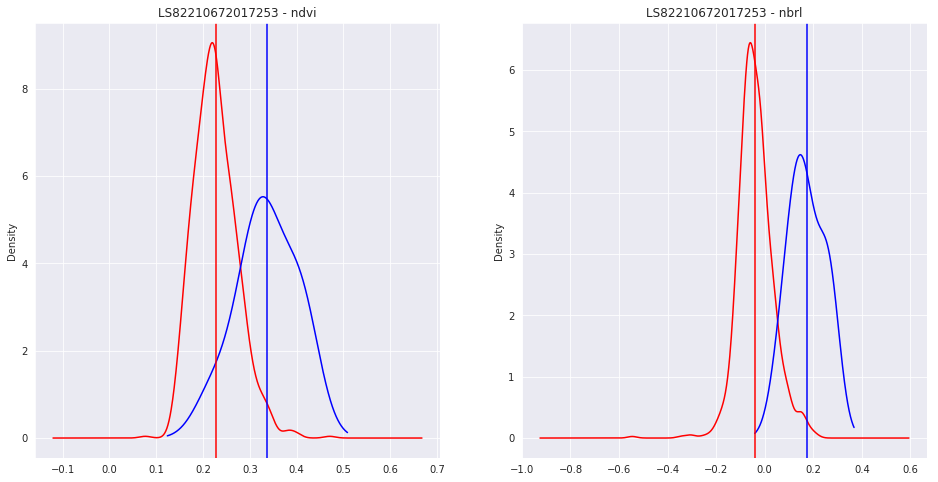

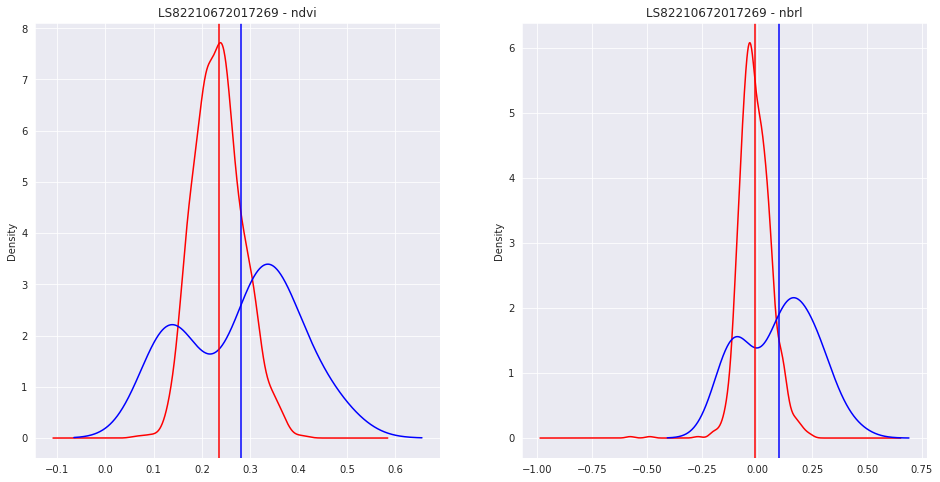

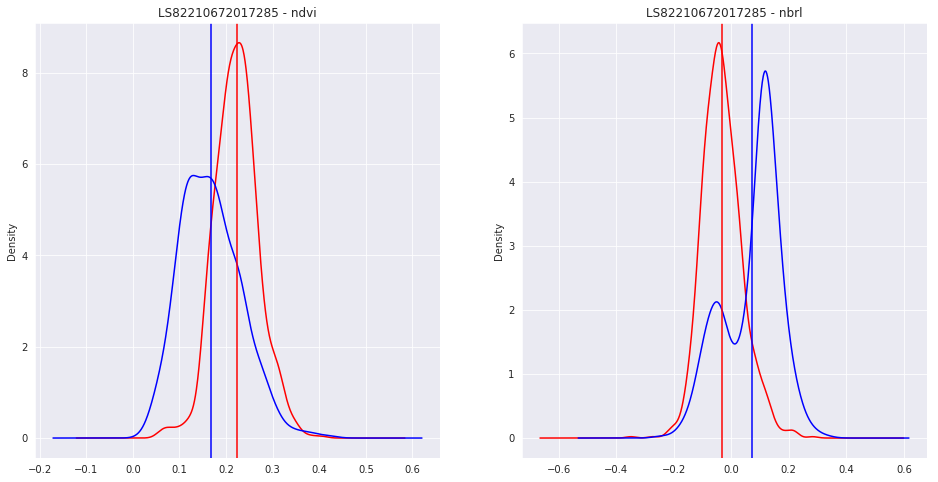

In [4]:
for i in id_cenas:
    fig, ax = plt.subplots(figsize=(16,8))
    d = df[df.id_cena==i].copy()
    d1 = d[d.verifica==1]
    d3 = d[d.verifica==3]
    
    col = 'ndvi'
    plt.subplot(1, 2, 1)
    plt.title('%s - %s' % (i, col))
    d1[col].plot.kde(c='r')
    d3[col].plot.kde(c='b')
    plt.axvline(d1[col].mean(), c='r')
    plt.axvline(d3[col].mean(), c='b')
    
    col = 'nbrl'
    plt.subplot(1, 2, 2)
    plt.title('%s - %s' % (i, col))
    d1[col].plot.kde(c='r')
    d3[col].plot.kde(c='b')
    plt.axvline(d1[col].mean(), c='r')
    plt.axvline(d3[col].mean(), c='b')

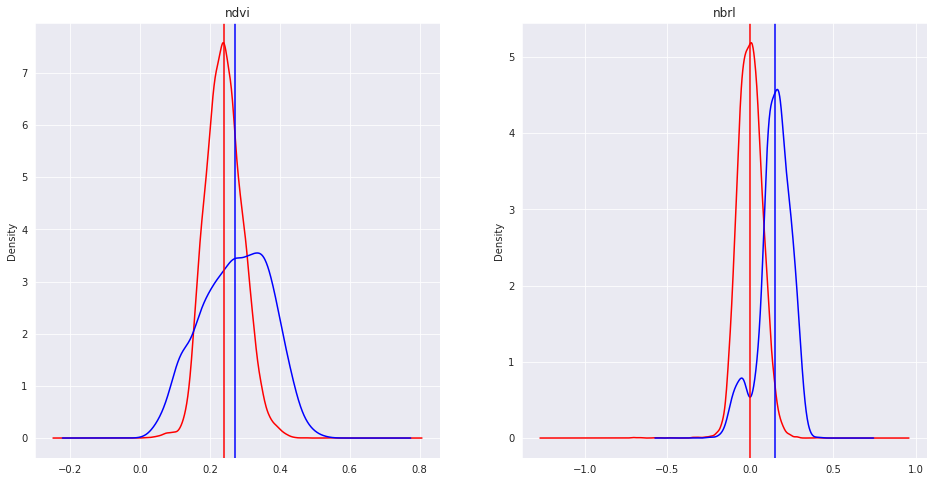

In [5]:
fig, ax = plt.subplots(figsize=(16,8))
d = df[df.id_cena.isin(id_cenas)]
d1 = d[d.verifica==1]
d3 = d[d.verifica==3]

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title(col)
d1[col].plot.kde(c='r')
d3[col].plot.kde(c='b')
plt.axvline(d1[col].mean(), c='r')
plt.axvline(d3[col].mean(), c='b')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title(col)
d1[col].plot.kde(c='r')
d3[col].plot.kde(c='b')
plt.axvline(d1[col].mean(), c='r')
plt.axvline(d3[col].mean(), c='b')

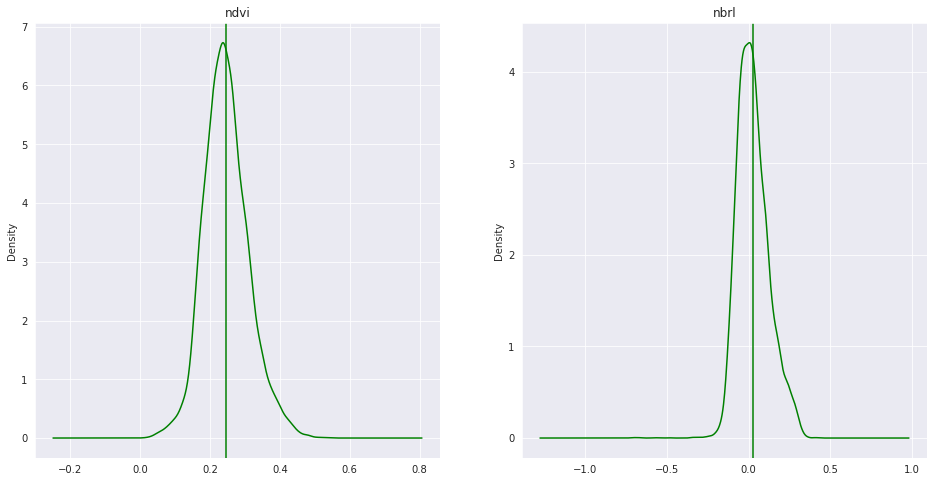

In [6]:
fig, ax = plt.subplots(figsize=(16,8))
d = df[df.id_cena.isin(id_cenas)]

col = 'ndvi'
plt.subplot(1, 2, 1)
plt.title(col)
d[col].plot.kde(c='g')
plt.axvline(d[col].mean(), c='g')

col = 'nbrl'
plt.subplot(1, 2, 2)
plt.title(col)
d[col].plot.kde(c='g')
plt.axvline(d[col].mean(), c='g')

In [7]:
modelo = df[df.id_cena.isin(id_cenas)]

In [8]:
print(len(modelo))

11480


In [9]:
print(modelo.id_cena.value_counts())

LS82210672017141    1810
LS82210672017285    1674
LS82210672017173    1167
LS82210672017157    1052
LS82210672017269    1047
LS82210672017189    1006
LS82210672017205     930
LS82210672017221     898
LS82210672017253     848
LS82210672017237     731
LS82210672017125     317
Name: id_cena, dtype: int64


In [10]:
id_cena = 'LS82210672017141'

## Remove cena selecionada do conhecimento

In [11]:
modelo = modelo[(modelo.id_cena!=id_cena)]

In [12]:
print(len(modelo))

9670


## Pega dados para classificar

In [13]:
# Dado que será classificado
teste = df[df.id_cena==id_cena].copy().reset_index(drop=True)

In [14]:
print(len(teste))

1810


In [15]:
print(teste.verifica.value_counts())

3    1091
1     719
Name: verifica, dtype: int64


## Escolhe colunas usandas nos classificadores

In [16]:
colunas = ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']

## Cria classificador com Random Forest

In [30]:
classificador = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Coeficiente GINI
GINI é um indice para definir a desigualdade, criado por um italiano estatistico, variando o valor de 0 a 1, onde:


    - Próximo de 0: Igualdade
    - Próximo de 1: Desigualdade

In [31]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb2,0.583597
1,ndvi,0.226337
2,medianb5,0.159543
3,nbrl,0.021643
4,dif_ndvi,0.006927
5,medianb6,0.001358
6,medianb3,0.000300
7,dif_dnbrl,0.000139
8,medianb4,0.000120
9,medianb7,0.000037


In [33]:
## Classifica usando usanfo Random Forest e usando todas colunas

In [34]:
teste['rf'] = classificador.predict(teste[colunas])

## Verifica resultado da classificação

In [67]:
def ver_resultado(dado, coluna_previsao, coluna_verdade):
    try:
        quantidade_acerto_verifica_1 = len(dado[(dado[coluna_previsao]==1) & (dado[coluna_verdade]==1)])
        total_veirifica1 = len(dado[dado[coluna_verdade]==1])
        porcentagem = int((quantidade_acerto_verifica_1*100)/total_veirifica1)
        return [len(dado), total_veirifica1, quantidade_acerto_verifica_1, porcentagem]
    except Exception as e:
        print(e)
        return e
        return [0, 0, 0]

In [68]:
ver_resultado(teste, 'rf', 'verifica')

[1810, 719, 688, 95]

## Testando com um modelo gerado com uma amostra de verifica 1 e 3 em mesma quantidade

In [69]:
modelo = df[df.id_cena.isin(id_cenas)] # Modelo com todas cenas da mesma orb_pto
modelo = modelo[(modelo.id_cena!=id_cena)] # Remove a cena atual do conhecimento

modelo_inteiro_1 = modelo[modelo.verifica==1]
modelo_inteiro_3_full = modelo[modelo.verifica==3]

if len(modelo_inteiro_3_full) > len(modelo_inteiro_1):
    id3 = np.random.choice(modelo_inteiro_3_full.id, len(modelo_inteiro_1), replace=False) 
    modelo_inteiro_3 = modelo_inteiro_3_full[modelo_inteiro_3_full.id.isin(id3)]
else:
    print('Existe mais verifica 1 do que 3')
    modelo_inteiro_3 = modelo_inteiro_3_full
    id1 = np.random.choice(modelo_inteiro_1.id, len(modelo_inteiro_3), replace=False) 
    modelo_inteiro_1 = modelo_inteiro_1[modelo_inteiro_1.id.isin(id1)]

modelo = pd.concat([modelo_inteiro_1, modelo_inteiro_3]).reset_index(drop=True)

Existe mais verifica 1 do que 3


In [70]:
modelo.verifica.value_counts()

3    965
1    965
Name: verifica, dtype: int64

## Cria classificador com Random Forest

In [71]:
classificador = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_features=len(colunas), random_state=0, max_depth=3, min_samples_split=5)
classificador.fit(modelo[colunas], modelo.verifica)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Indice GINI

In [72]:
rank = pd.DataFrame(sorted(list(zip(colunas,classificador.feature_importances_)), key=lambda x: x[1], reverse=True), columns=['coluna', 'gini'])
rank

,coluna,gini
0,medianb5,0.635796
1,nbrl,0.230325
2,ndvi,0.062540
3,medianb6,0.034076
4,dif_ndvi,0.031818
5,medianb3,0.003162
6,dif_dnbrl,0.001315
7,medianb2,0.000509
8,medianb7,0.000248
9,medianb4,0.000212


## Classifica com Random Forest

In [73]:
teste['rf'] = classificador.predict(teste[colunas])

## Verifica resultado da classificação

In [74]:
ver_resultado(teste, 'rf', 'verifica')

[1810, 719, 695, 96]